People are more likely to be born at the weekend 
---------
How many births are there each day? The number of births per day isn't totally random - a non-negligible fraction are induced, and so can be (to some extent) scheduled in advance. Since they are unlikely to be scheduled for the weekend, this leads to the headline above - a random person is more likely to have been born on a weekday that at the weekend. We're not here to delve too deeply into the _why_, however. We're here to play around with some data, to find the magnitude of the weekend effect, and explore what other effects we can see. (We're also here so I can practice using Pandas and Scikit-learn!)

Results (spoilers!)
---------
For a given year, the joint largest effect we see in this model is the **weekend** effect, reducing the number of births on those days by around 18\%.
Joint with that, it turns out, is a **bank holiday** effect - this is obvious in retrospect, but as we will see it is nicely forced on us by the data. 
The **year-on-year trend** is about as important too, however, and this trend seems quite erratic. The births in a given year are well correlated with the previous year's mean births for each of the years in the sample, so we find that this suffices as a predictor.
**New year's day** has the same reduction as a bank holiday, but **Christmas day** (and the day after) both have an extra 10\% reduction, for a total average reduction of 28\%.
**September** has a large increase over the mean, of 5\% (and **July** is similar, at 3%).
Finally, and possibly surprisingly,
the 13th of the month has a small but significant reduction of 2\%.

The factors we include in our model explain roughly 85\% of the variance, and the residuals are indistinguishable from normally distributed (at 95% CL).

Model Choice
------------
We will use basic linear regression for this exploration. We have tested using Lasso regularization as well - for a wide range of values of the alpha parameter of that model (from 0.1 simple to 100.0) the results (both coefficients and score) change only insignificantly, so we can judge our results is be fairly robust. Since most of our features will turn out to be categorical, we could also consider using a decision tree, however the simple interpretability of the coefficients of our linear model is a nice feature to have.

To Do
------
* Test significance of each coefficient, find minimal number of features.
* Rewrite data scaling using a sklearn.pipeline.Pipeline.
* To what significance can we claim to have detected Christmas? (à la Higgs boson)
* Is there a difference between Christmas and bank holidays, except that the latter gets washed out in the year-averaging?
* Add in full seasonality, not just a September and July offset. Either one-hot encode all months, or use a time series model, eg ARIMA.
* Quantify autocorrelation.
* Any interactions?
* Play with some clustering algorithm to see if it can pick out types of days.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats
month_names = dict(zip(range(1,13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']))
day_names = dict(zip(range(0,7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']))

lasso_alpha = 0.0

Data Source
---------
We will use data on the number of live births by date, from 1995 to 2016 in England and Wales, obtained from the Office for National Statistics:
https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/livebirths/adhocs/009036numberoflivebirthsbydate1995to2016inenglandandwales/

Let's load in the data and take a quick look at the datatypes in the columns.

In [2]:
df = pd.read_excel("adhocbirthsbydate1995to2016.xls",'Data')
column_names = df.iloc[3]
df.columns = column_names
df = df.iloc[4:370]
df.columns.name=None
df = df.reset_index(drop=True)
print(df.dtypes[:10])
#df.head()

Date       object
2016.0    float64
2015       object
2014       object
2013       object
2012       object
2011       object
2010       object
2009       object
2008.0    float64
dtype: object


That's a bit weird - some of the leap years are numerical, but something else is going on with the other years. Let's print the leap day row to see how the data format deals with leap days.

In [3]:
print(df[df['Date']=='29/02'])

     Date  2016.0 2015 2014 2013  2012 2011 2010 2009  2008.0  ...  2004.0  \
59  29/02  1855.0    z    z    z  2021    z    z    z  1982.0  ...  1426.0   

   2003 2002  2001  2000.0 1999 1998  1997  1996.0 1995  
59    z    z     z  1696.0    z    z     z  1816.0    z  

[1 rows x 23 columns]


Having those gaps in the data is annoying to deal with. Let's transform the data, from one column per year to one long series. We'll also keep 2016 to one side, so we have some clean test data to vaildate our model on.

For a bit of context, the mean and standard deviation of the births from 1995 to 2015:

In [4]:
all_series = []
## # Exclude 2016 for testing purposes.
for col in df.columns[2:][::-1]:
    temp = df[col][df[col]!='z']
    year = str(int(temp.name))
    dated_temp = pd.DataFrame([df['Date'][df[col]!='z']+'/'+year,temp]).T
    dated_temp.columns = ['Date','Births']
    dated_temp['Date'] = pd.to_datetime(dated_temp['Date'], format="%d/%m/%Y")
    all_series.append(dated_temp)
## # Separate 2016 data
col_2016 = df.columns[1]
temp = df[col_2016][df[col_2016]!='z']
year = str(int(temp.name))
dated_temp = pd.DataFrame([df['Date'][df[col_2016]!='z']+'/'+year,temp]).T
dated_temp.columns = ['Date','Births']
dated_temp['Date'] = pd.to_datetime(dated_temp['Date'], format="%d/%m/%Y")
data_2016 = dated_temp.copy(deep=True)

all_series = pd.concat(all_series)
all_series['Births'] = all_series['Births'].astype('float64')
data_2016['Births'] = data_2016['Births'].astype('float64')
#all_series.sum(numeric_only=True)
#print(all_series.dtypes)
print('Mean birth rate  \t', np.round(all_series['Births'].mean(),2))
print('Std of birth rate\t', np.round(all_series['Births'].std(),2))

Mean birth rate  	 1817.94
Std of birth rate	 207.85


Let's plot some data
---------------------
Okay, now we have a tidy series listing the births from 1995 to 2015 inclusive. Let's take a look at what we're dealing with, by plotting the birth data for 1995.

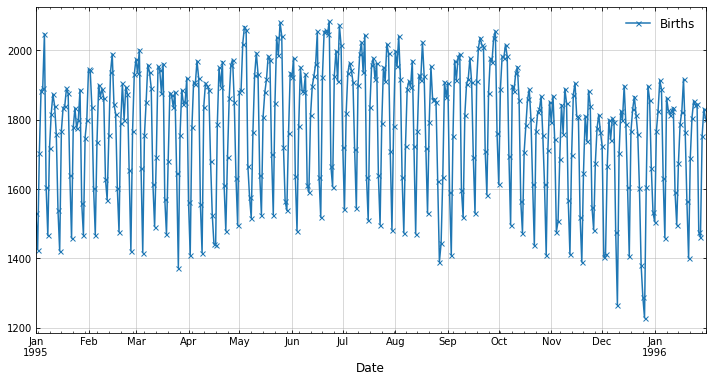

In [5]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
all_series[all_series['Date']<'1996-02-01'].plot('Date', 'Births', style='x-', ax=ax)
plt.show()

There's a lot going on here! There are clear regular dips - these turn out to be at the weekends. There is also some variation over the course of the year, higher in summer and lower in the winter. We don't want to conclude too much from just looking at one year though, as we might get fooled by random noise. Let's use all the data, and take averages to see the dependance on year, month, date and day of week.

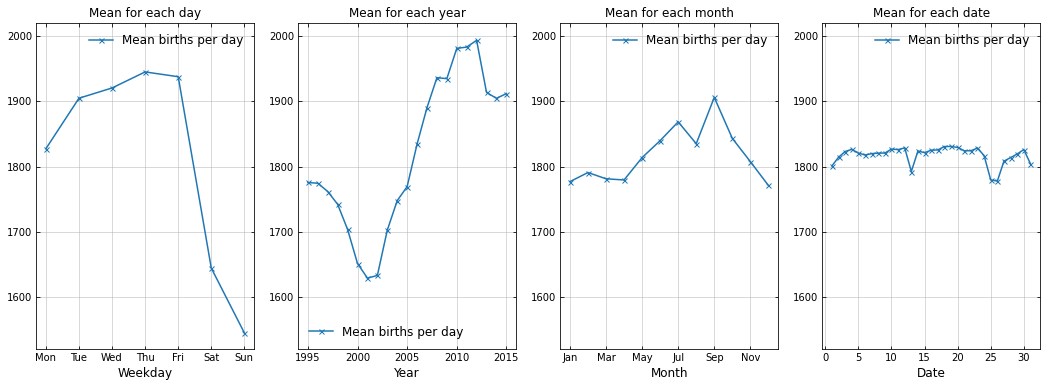

In [6]:
fig, axs = plt.subplots(1,4,figsize=(18,6))
axs = axs.flatten()
all_series.groupby(all_series['Date'].dt.year)['Births'].mean().plot(xlabel='Year', label='Mean births per day', style='x-', ax=axs[1])
axs[1].set_title('Mean for each year')
all_series.groupby(all_series['Date'].dt.month)['Births'].mean().plot(xlabel='Month', label='Mean births per day', style='x-', ax=axs[2])
axs[2].set_title('Mean for each month')
axs[2].set_xticks(list(month_names.keys())[::2])
axs[2].set_xticklabels(list(month_names.values())[::2])
all_series.groupby(all_series['Date'].dt.day)['Births'].mean().plot(xlabel='Date', label='Mean births per day', style='x-', ax=axs[3])
axs[3].set_title('Mean for each date')
all_series.groupby(all_series['Date'].dt.dayofweek)['Births'].mean().plot(xlabel='Weekday', label='Mean births per day', style='x-', ax=axs[0])
axs[0].set_title('Mean for each day')
axs[0].set_xticks(list(day_names.keys()))
axs[0].set_xticklabels(list(day_names.values()))
for i in range(len(axs)):
    axs[i].set_ylim(1520, 2020)
    axs[i].legend()
plt.show()

This is a lot clearer! There is some increase Monday to Friday, but a huge dip at the weekends. The variation year-on-year is very significant too - from this data we can see there is a correlation between the mean births in each year and the next, but to do any better than that it seems likely that we'll have to go beyond this data set, possibly looking at economic indicators. Beyond those two effects, there is also a large September effect, and dips around the start, 13th, 25th and end of the month. This plot has been averaged over all months, so it seems likely that the dip at the 25th is a residual Christmas effect, and ditto for a residual New Year's effect at the start and end of the month. The dip at the 13th is less obvious - perhaps people avoid that date due to superstition, in which case it is probably a smaller effect than Christmas, but one that happens every month. But let's test all this - let's plot the data, averaged over years but grouped by month.

In [7]:
all_series['dayofweek'] = all_series['Date'].dt.dayofweek
outliers_df = all_series[np.abs(stats.zscore(all_series['Births'])) > 2.5]
#print('(Outlier feature, count)')
#print('Month', Counter(outliers_df['Date'].dt.month).most_common(3))
#print('Year', Counter(outliers_df['Date'].dt.year).most_common(3))
#print('Day of week', Counter(outliers_df['dayofweek']).most_common(3))

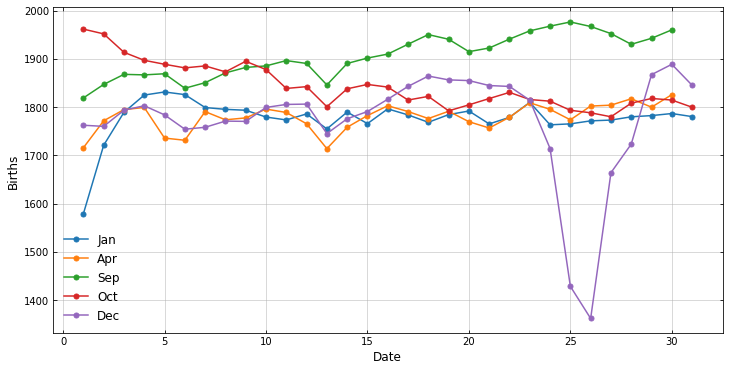

In [8]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
for temp_index in [1,4,9,10,12]:#range(1,13):
    inds_to_plot = all_series['Date'].dt.month==temp_index
    all_series[inds_to_plot].groupby(all_series[inds_to_plot]['Date'].dt.day)['Births'].mean().plot(style='-o', label=month_names[temp_index])
plt.ylabel('Births')
plt.legend()
#plt.savefig('births_vs_date_by_month.png')
plt.show()

Here we can see things even more clearly. The Christmas drop is large, around 25\%, and the New Year's day drop is about half that. There is a broad peak in late September/early October. Also, there is a dip in every month on the 13th!

Building a model
-----------------------------------
Based on the plots above, we can guess at some important features.
Most of these features will be binary, indicating whether or not a day is:
* a weekend
* Christmas (by which we will mean the 25th and 26th Dec)
* New Year's day
* in September
* in July
* the 13th of the month

We could one-hot encode all the months to capture the full seasonal effect, but we will limit ourselves to September and July in an attempt to keep the model as simple as possible.

The last feature we will add is an attempt to capture the **yearly** variation. We could possibly find some underlying predictor, maybe some economic metric, or the population size of the appropriate age group. We'll keep things simple here however - using the fact that the mean births for each year appear to be correlated with the previous year, we will use the previous year's mean births as a feature in our model.

One last thing to note: we can probably expect the effect of these features to be a **fractional** change in the number of births that day. To better fit this, and to aid in the interpretability of our model, we will multiply each of the above features by the previous year's mean births. This isn't just a scaling, as of course the previous year's mean births will be different for each year. Having done this, the coefficients of the features in our simple linear regression will approximate the real *fractional* effect, not some absolute effect.

In [9]:
## # Note there is a bit of leakage of Test into Train here, but only through the mean births in the previous year, and there is no leakage from 2016.
year_means = all_series.groupby(all_series['Date'].dt.year)['Births'].mean()
#print(year_means.index)
year_offset = {i:j for i,j in zip(year_means.index,year_means.values)}
#print(year_offset)
years = all_series['Date'].dt.year.values
all_series['year_mean_offset'] = np.array([year_offset[yr-1] if yr>1995 else year_means.mean() for yr in years])
scale = all_series['year_mean_offset']
#all_series.head()

ny_dates    = [all_series['Date'].dt.strftime('%m-%d')=='01-01']
xmas_dates  = [all_series['Date'].dt.strftime('%m-%d')=='12-25']
xmas_dates += [all_series['Date'].dt.strftime('%m-%d')=='12-26']
thirteenth_dates = [all_series['Date'].dt.day==13]
all_series['is_thirteenth'] = scale*np.any(thirteenth_dates, axis=0)
all_series['is_weekend']    = scale*np.any([all_series['dayofweek']==5, all_series['dayofweek']==6], axis=0)
all_series['is_xmas']       = scale*np.any(xmas_dates, axis=0)
all_series['is_ny']         = scale*np.any(ny_dates, axis=0)
## # Could use get_dummies
all_series['is_sep'] = scale*np.any([all_series['Date'].dt.month==9], axis=0)
all_series['is_jul'] = scale*np.any([all_series['Date'].dt.month==7], axis=0)
#print(all_series.dtypes)
print('Quick sanity check: do we have the right counts of each feature per year? (It won\'t be perfect because of leap years.)')
print(all_series[['is_thirteenth','is_weekend','is_xmas','is_ny','is_sep','is_jul']].sum(numeric_only=True)*365.25/(np.sum(scale)))
#all_series[['Date','is_xmas', 'is_weekend']].tail(10)

Quick sanity check: do we have the right counts of each feature per year? (It won't be perfect because of leap years.)
is_thirteenth     12.000401
is_weekend       104.337163
is_xmas            2.000067
is_ny              1.000033
is_sep            30.001002
is_jul            31.001036
dtype: float64


In [10]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [11]:
#print(all_series.columns)
features_to_use = ['is_jul', 'is_thirteenth', 'is_weekend', 'is_sep', 'year_mean_offset', 'is_xmas', 'is_ny']
print('Feature list:', features_to_use)
#print(all_series[features_to_use].mean())

Feature list: ['is_jul', 'is_thirteenth', 'is_weekend', 'is_sep', 'year_mean_offset', 'is_xmas', 'is_ny']


We'll do a train-test split, taking a random sample of 67% of the days from 1995 to 2015 to train on. We'll train a simple linear regression model.

The aim of adding features to our model is to explain the variance seen in the initial data set. To quantify the variance explained by our model we use the "score": the reduction in the variance (before and after subtracting off the model prediction), divided by the original variance.

What score do we get?

In [12]:
## # To do: add scaler to pipeline
indices = range(len(all_series['Births'].values))
X_train, X_test, y_train, y_test, inds_train, inds_test = train_test_split(all_series[features_to_use].values, all_series['Births'].values, indices, test_size=0.33, random_state=42)

In [13]:
if lasso_alpha > 0:
    ## # Should scale the features properly, and set it up with a Pipeline.
    ## # Seems sufficiently robust already though - the difference in the feature scales
    ## # isn't too drastic, and changing lasso_alpha from 0 has negligible effect. 
    reg = Lasso(alpha=lasso_alpha).fit(X_train, y_train)
    print(f'Fitting with Lasso, alpha={lasso_alpha}.')
else:
    reg = LinearRegression().fit(X_train, y_train)
    print(f'Fitting with LinearRegression.')
print('Score:',round(reg.score(X_test, y_test),2))
#print('Frac variance expl:',1-np.sum((reg.predict(X_test)-y_test)**2)/np.sum((y_test-y_test.mean())**2))
#for pair in zip(features_to_use, reg.coef_):
#    print(*pair, sep='\t')
#print(reg.intercept_)

Fitting with LinearRegression.
Score: 0.79


That's pretty good! But let's see what the distribution of the residuals looks like to see if there's an obvious way to improve our model.
To do that, we'll use the SciPy function "normaltest", which provides a pvalue that tests the null hypothesis that a sample comes from a normal distribution. We'll also plot a histogram of the residual errors of the model on the training data, and a histogram of the original birth data with the mean subtracted for comparison.

Normal test p-value:
9.794716339453243e-147


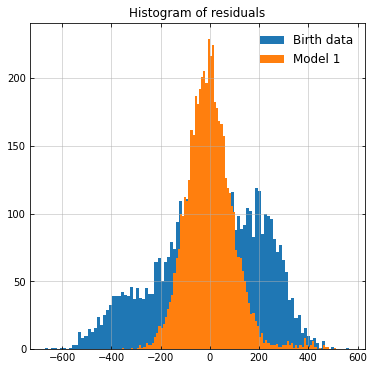

In [14]:
diffs = reg.predict(X_train)-y_train
print('Normal test p-value:')
cut=3.5
cut_diffs = diffs[np.abs(stats.zscore(diffs)) < cut]
#print(f'Cut at {str(cut)}:',stats.normaltest(cut_diffs).pvalue, sep='\t')
print(stats.normaltest(diffs).pvalue, sep='\t')

diff_outlier_inds = np.abs(stats.zscore(diffs)) > cut
pred_outliers = pd.DataFrame(X_train[diff_outlier_inds], columns=features_to_use)
#print(pred_outliers[:5])
#print(diffs.std())

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_title('Histogram of residuals')
plt.hist(y_train-y_train.mean(), label='Birth data', bins=100)
plt.hist(diffs, label='Model 1', bins=100)
plt.legend()
plt.show()

That's a lot closer to normal than the original data, but still pretty far from perfect! With such a tiny p-value we can definitely reject the null hypothesis at the 95% confidence level. We have a lot of outliers, especially where our model is overpredicting.

In [15]:
print(f'Let\'s take a closer look at the outliers, with z>{cut}')
print(f'Mean of outliers:',round(y_train[diff_outlier_inds].mean(),2))
full_train = all_series.iloc[inds_train]
outliers_count = Counter(full_train.iloc[diff_outlier_inds]['Date'].dt.dayofweek.values).most_common(10)
print(f'What days are the outliers?')
print('Day\tCount')
for pair in outliers_count:
    print(day_names[pair[0]], pair[1], sep='\t')

Let's take a closer look at the outliers, with z>3.5
Mean of outliers: 1503.51
What days are the outliers?
Day	Count
Mon	42
Tue	2
Sun	1


From looking at this we can tell we're overpredicting births on a bunch of days, nearly all of which (42 out of 45) are Mondays - we forgot bank holidays! In retrospect this is obvious, but it\'s nice to see this conclusion forced upon us by the data.

Let's add information about bank holidays to our feature list; a little bit of searching leads to a nicely formatted list at https://www.dmo.gov.uk/ . Unfortunately it only has data from 1998+, so we'll restrict our main dataset to that period too, between 1998 and 2015 inclusive.

In [16]:
ukbankholidays = pd.read_excel("ukbankholidays.xls")
ukbankholidays = ukbankholidays[pd.notnull(ukbankholidays['UK BANK HOLIDAYS'])]

Let's print the most common dates in this dataset, and the range of dates:

In [17]:
data_after_1998 = all_series[all_series['Date']>=ukbankholidays['UK BANK HOLIDAYS'].iloc[0]].copy(deep=True)
data_after_1998['is_bank_holiday'] = data_after_1998['year_mean_offset']*np.array([d in ukbankholidays['UK BANK HOLIDAYS'].values for d in data_after_1998['Date'].values])
bank_hols_count = Counter(ukbankholidays['UK BANK HOLIDAYS'].dt.strftime('%m-%d')).most_common(10)
print('Bank hol dates,\tCount')
for pair in bank_hols_count:
    print(*pair, sep=',\t')
#print(data_after_1998[['is_weekend','is_bank_holiday']][data_after_1998['Date'].dt.strftime('%m-%d')=='01-01'])
print('Start:', ukbankholidays['UK BANK HOLIDAYS'].min())
print('End  :', ukbankholidays['UK BANK HOLIDAYS'].max())

Bank hol dates,	Count
01-01,	80
12-25,	80
12-26,	80
12-28,	33
12-27,	33
05-03,	17
05-31,	17
08-30,	17
01-03,	17
05-07,	17
Start: 1998-01-01 00:00:00
End  : 2110-12-26 00:00:00


So this list actually includes New Year's and Christmas, for 80/112 = 5/7 of the total years, i.e. whenever it didn't already fall on a weekend. This means that if we include it, the Christmas and New Year's coefficients will be the excess above the bank holiday level - it would be more robust to separate these effects out, or include interaction terms, but for the moment we'll leave it as is and see how things go.

In [18]:
new_features_to_use = features_to_use+['is_bank_holiday']
print('New features:', new_features_to_use)

New features: ['is_jul', 'is_thirteenth', 'is_weekend', 'is_sep', 'year_mean_offset', 'is_xmas', 'is_ny', 'is_bank_holiday']


In [19]:
## # Note same random state
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(data_after_1998[new_features_to_use].values, data_after_1998['Births'].values, test_size=0.33, random_state=42)

What is the score of this new model, and what size are the coefficients? (Don't forget that is_xmas and is_ny are capturing the excess of Christmas and New Year's, over and above the weekend/bank holiday effect!)


In [20]:
if lasso_alpha>0:
    ## # Should scale the features properly, and set it up with a Pipeline.
    ## # Seems sufficiently robust already though - the difference in the feature scales
    ## # isn't too drastic, and changing lasso_alpha from 0 has negligible effect.
    new_reg = Lasso(alpha=lasso_alpha).fit(new_X_train, new_y_train)
    print(f'Fitting with Lasso, alpha={lasso_alpha}.')
else:
    new_reg = LinearRegression().fit(new_X_train, new_y_train)
    print(f'Fitting with LinearRegression.')
print('Score:',round(new_reg.score(new_X_test, new_y_test),2))
#print('Frac variance expl:',1-np.sum((new_reg.predict(new_X_test)-new_y_test)**2)/np.sum((new_y_test-new_y_test.mean())**2))
rounded_coeffs = [round(x,2) for x in list(new_reg.coef_)+[new_reg.intercept_]]
display_labels = new_features_to_use+['intercept']
display_table = pd.DataFrame(zip(display_labels,rounded_coeffs), columns=['Feature name', 'coeff'])
display_table = display_table.reindex(display_table['coeff'].abs().sort_values().index[::-1]).reset_index(drop=True)
display_table

Fitting with LinearRegression.
Score: 0.85


,Feature name,coeff
0,intercept,104.28
1,year_mean_offset,1.00
2,is_bank_holiday,-0.18
3,is_weekend,-0.18
4,is_xmas,-0.10
5,is_sep,0.05
6,is_jul,0.03
7,is_thirteenth,-0.02
8,is_ny,0.01


Interpretation: a bank holiday or weekend reduces births by around 18%, and Christmas reduces by <span style="color:red">another</span> 10%. New year's day has almost no excess above the weekend base level, which matches what we saw in the plots above. September and July have increased births by 5% and 3% respectively, but the 13th of the month seems to decrease births by around 2%. (To test the robustness of this the same model can be fit but with some other date singled out, in which case the effect vanishes - people do treat the 13th differently!)

The year_mean_offset coefficient and intercept are a little trickier to interpret - the mean birth rate for a random weekday (which doesn't fall into any of the feature categories) will be 1.00 multiplied by the previous year's mean birth rate (over *every* day in that year) plus the intercept. We could set up the model so the interpretation is a bit clearer, but since the year-on-year trend is driven by factors that we do not have in this data, there is only so much insight to be gained in that direction - probably better to focus on pinning down the effects of the other features.

Normal test p-value:
0.91


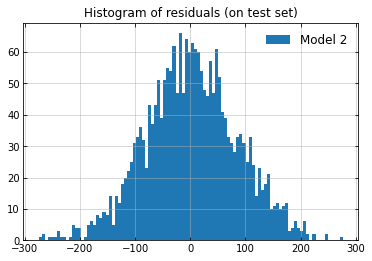

In [21]:
new_diffs = new_reg.predict(new_X_test)-new_y_test
print('Normal test p-value:')
print(round(stats.normaltest(new_diffs).pvalue,2), sep='\t')
plt.title('Histogram of residuals (on test set)')
plt.hist(new_diffs, label='Model 2', bins=100)
plt.legend()
plt.show()

That p-value is consistent with normal, at the 95% confidence level! Cool, we've got a pretty good model with no obvious patterns left in the residuals.

Note: since all our features (except the previous year's mean births) are categorical, we probably could have done as well with a decision tree with some regressed offset, but the interpretability of the coefficients in this model are a nice bonus.

For the grand finale, let's test on 2016, the year that we totally kept out of the training and testing data so far.

To do this we'll set up the features for 2016, and do a quick sanity check to make sure we've counted all of each type of day in that year.

In [22]:
print(new_features_to_use)
data_2016['year_mean_offset'] = year_means[2015]
data_2016['is_jul']           = year_means[2015]*(data_2016['Date'].dt.month==7)
data_2016['is_thirteenth']    = year_means[2015]*(data_2016['Date'].dt.day==13)
data_2016['is_weekend']       = year_means[2015]*(data_2016['Date'].dt.dayofweek>4)
data_2016['is_sep']           = year_means[2015]*(data_2016['Date'].dt.month==9)
data_2016['is_xmas']          = year_means[2015]*(np.any([(data_2016['Date'].dt.strftime('%m-%d')=='12-25'),(data_2016['Date'].dt.strftime('%m-%d')=='12-26')], axis=0))
data_2016['is_ny']            = year_means[2015]*(np.any([(data_2016['Date'].dt.strftime('%m-%d')=='01-01')], axis=0))
data_2016['is_bank_holiday']  = year_means[2015]*(np.array([d in ukbankholidays['UK BANK HOLIDAYS'].values for d in data_2016['Date'].values]))
data_2016['pred_births']      = new_reg.predict(data_2016[new_features_to_use].values)
print(data_2016[['is_jul', 'is_thirteenth', 'is_weekend', 'is_sep', 'is_xmas', 'is_ny', 'is_bank_holiday']].sum(numeric_only=True)/year_means[2015])

['is_jul', 'is_thirteenth', 'is_weekend', 'is_sep', 'year_mean_offset', 'is_xmas', 'is_ny', 'is_bank_holiday']
is_jul              31.0
is_thirteenth       12.0
is_weekend         105.0
is_sep              30.0
is_xmas              2.0
is_ny                1.0
is_bank_holiday      8.0
dtype: float64


Score on 2016: 0.86


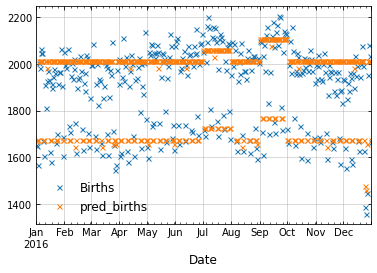

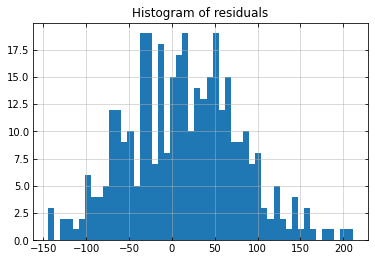

Normal test p-value:
0.4


In [23]:
print('Score on 2016:', round(new_reg.score(data_2016[new_features_to_use].values, data_2016['Births'].values),2))
data_2016.plot('Date', ['Births', 'pred_births'], style='x')
diffs = data_2016['pred_births']-data_2016['Births']
plt.show()
plt.title('Histogram of residuals')
plt.hist(diffs, bins=50)
plt.show()
print('Normal test p-value:')
print(round(stats.normaltest(diffs).pvalue,2), sep='\t')

Conclusions
-----------
Testing on the 2016 data, we get a score of 0.86 and a p-value that indicates the residuals are indistinguishable from normally distributed at the 95% confidence level. That sounds like a success! The initial data had a standard deviation of around 200; since our residuals are only around 65, our simple model enables much more precise predictions to be made.

Anyway, thanks for reading! I wrote this up to practice playing around with Pandas and Scikit-learn, but hopefully you enjoyed the exploration of the dataset too. Feel free to email me if you have any comments or suggestions! 

(P.S. See below for a few more rough checks I ran on the model, if you're curious.)

In [24]:
## # What happens if we drop each feature?
#print('Dropped feature\t\tNormal?\tScore')
#for i in range(np.shape(new_X_train)[1]):
#    temp_X_train = np.delete(new_X_train,i,1)
#    temp_X_test = np.delete(new_X_test,i,1)
#    if lasso_alpha>0:
#        temp_reg = Lasso(alpha=lasso_alpha).fit(temp_X_train, new_y_train)
#    else:
#        temp_reg = LinearRegression().fit(temp_X_train, new_y_train)
#    temp_diffs = temp_reg.predict(temp_X_test)-new_y_test
#    space_offset = 20-len(new_features_to_use[i])
#    print(f'{new_features_to_use[i]}'+' '*space_offset,end='\t')
#    print(round(stats.normaltest(temp_diffs).pvalue,3), round(temp_reg.score(temp_X_test, new_y_test),3), sep='\t')

In [25]:
## # Outliers in 2016
#print(data_2016[np.abs(stats.zscore(diffs)) > 2.5])
#print([day_names[x] for x in data_2016['Date'][np.abs(stats.zscore(diffs)) > 2.5].dt.dayofweek])

In [26]:
#fig, ax = plt.subplots(1,1,figsize=(12,6))
#date_range = data_2016['Date']>'2016-12-01'
#date_range = data_2016['Date']<'2016-01-30'
#data_2016[date_range].plot('Date', 'Births', style='-x', ax=ax)
#data_2016[date_range].plot('Date', 'pred_births', style='-x', ax=ax)
#plt.show()

In [27]:
## # Scores on 2016
#lasso_alpha, score, normal_test
#0.0, 0.86, 0.40
#0.1, 0.86, 0.40
#1.0, 0.86, 0.40
#10.0, 0.86, 0.39
#100.0, 0.86, 0.38
#10000.0, 0.67, 0.0